# Imports

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram
from IPython.display import clear_output
!pip install ucimlrepo
clear_output()
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

# Constants

In [ ]:
SEED = 42

# Preparing Datasets

## Blobs Dataset

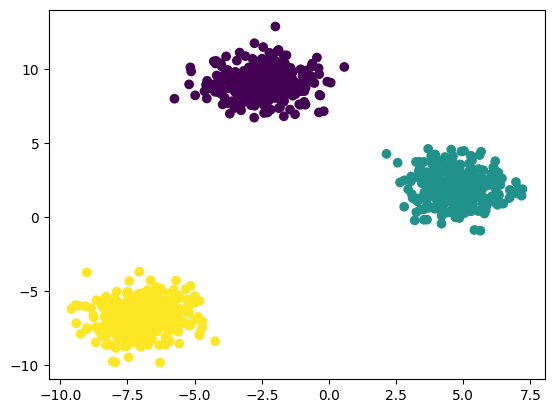

In [ ]:
blobs_X, blobs_y = make_blobs(n_samples=1000, random_state=SEED)
plt.scatter(blobs_X[:, 0], blobs_X[:, 1], c=blobs_y)
plt.show()

## Noisy Moons Dataset

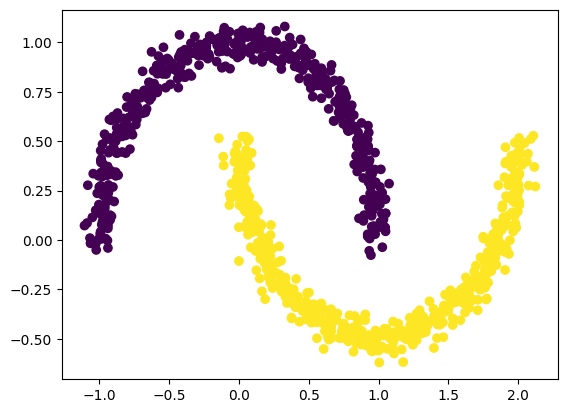

In [ ]:
noisy_moons_X, noisy_moons_y = make_moons(n_samples=1000, noise=0.05, random_state=SEED)
plt.scatter(noisy_moons_X[:, 0], noisy_moons_X[:, 1], c=noisy_moons_y)
plt.show()

## Noisy Circles Dataset

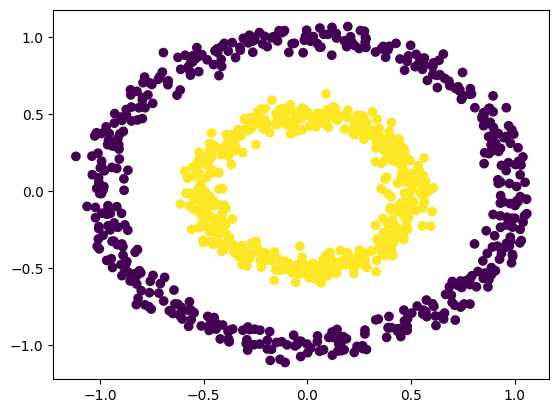

In [ ]:
noisy_circles_X, noisy_circles_y = make_circles(n_samples=1000, factor=0.5, noise=0.05, random_state=SEED)
plt.scatter(noisy_circles_X[:, 0], noisy_circles_X[:, 1], c=noisy_circles_y)
plt.show()

## Anisotropicly Distributed Dataset

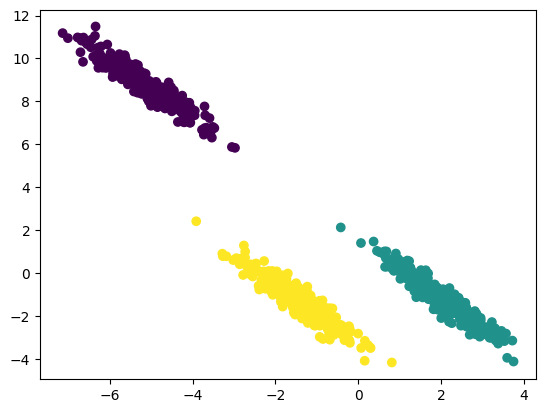

In [ ]:
aniso_X, aniso_y = make_blobs(n_samples=1000, random_state=SEED)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
aniso_X = np.dot(aniso_X, transformation)
plt.scatter(aniso_X[:, 0], aniso_X[:, 1], c=aniso_y)
plt.show()

## Varied Variances Blobs Dataset

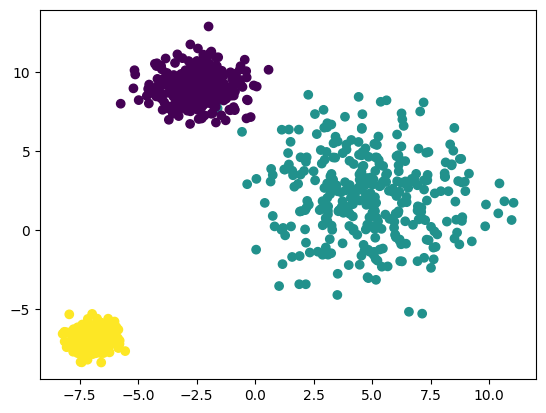

In [ ]:
varied_blobs_X, varied_blobs_y = make_blobs(n_samples=1000, cluster_std=[1.0, 2.5, 0.5], random_state=SEED)
plt.scatter(varied_blobs_X[:, 0], varied_blobs_X[:, 1], c=varied_blobs_y)
plt.show()

## No Structure Dataset

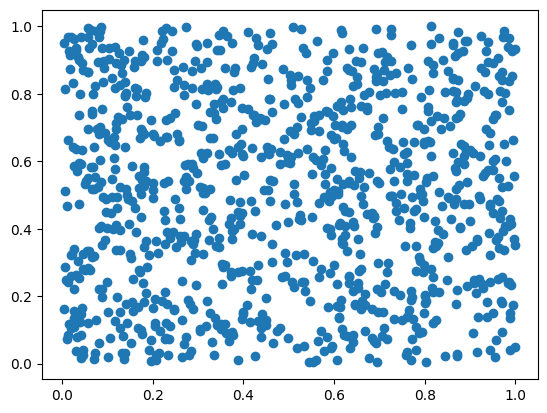

In [ ]:
rng = np.random.RandomState(SEED)
no_structure_X = rng.rand(1000, 2)
plt.scatter(no_structure_X[:, 0], no_structure_X[:, 1])
plt.show()

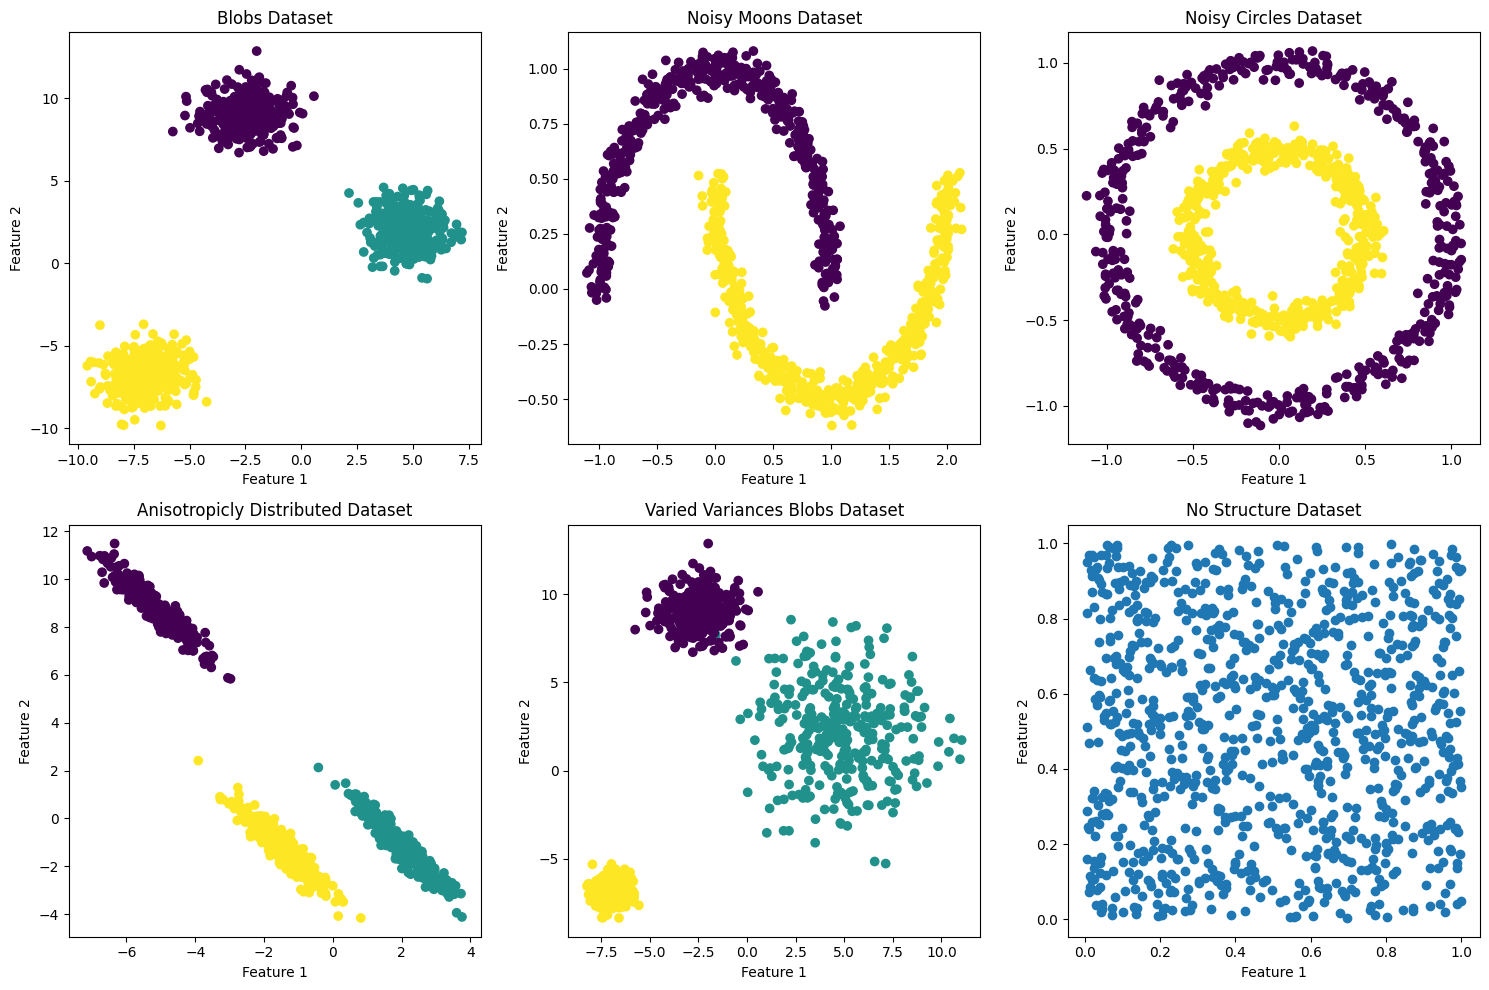

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].scatter(blobs_X[:, 0], blobs_X[:, 1], c=blobs_y)
ax[0, 0].set_title("Blobs Dataset")
ax[0, 0].set_xlabel("Feature 1")
ax[0, 0].set_ylabel("Feature 2")
ax[0, 1].scatter(noisy_moons_X[:, 0], noisy_moons_X[:, 1], c=noisy_moons_y)
ax[0, 1].set_title("Noisy Moons Dataset")
ax[0, 1].set_xlabel("Feature 1")
ax[0, 1].set_ylabel("Feature 2")
ax[0, 2].scatter(noisy_circles_X[:, 0], noisy_circles_X[:, 1], c=noisy_circles_y)
ax[0, 2].set_title("Noisy Circles Dataset")
ax[0, 2].set_xlabel("Feature 1")
ax[0, 2].set_ylabel("Feature 2")
ax[1, 0].scatter(aniso_X[:, 0], aniso_X[:, 1], c=aniso_y)
ax[1, 0].set_title("Anisotropicly Distributed Dataset")
ax[1, 0].set_xlabel("Feature 1")
ax[1, 0].set_ylabel("Feature 2")
ax[1, 1].scatter(varied_blobs_X[:, 0], varied_blobs_X[:, 1], c=varied_blobs_y)
ax[1, 1].set_title("Varied Variances Blobs Dataset")
ax[1, 1].set_xlabel("Feature 1")
ax[1, 1].set_ylabel("Feature 2")
ax[1, 2].scatter(no_structure_X[:, 0], no_structure_X[:, 1])
ax[1, 2].set_title("No Structure Dataset")
ax[1, 2].set_xlabel("Feature 1")
ax[1, 2].set_ylabel("Feature 2")
fig.tight_layout()
fig.show()

## Real World Dataset

In [ ]:
adult = fetch_ucirepo(id=2)
adult_dataset = pd.concat((adult.data.features, adult.data.targets), axis=1)

### Preprocessing the Dataset

In [ ]:
def data_preparation(df: pd.DataFrame, parameters: dict = dict()):
    """
    parameters dict may have these keys:
    scaler, ordinal_encoder, label_encoder, mapping_dicts,
    categorical_imputer, numerical_imputer, etc...
    """

    # handle missing and unknown values
    df = df.dropna()
    df = df[(df['workclass'] != '?') & (df['native-country'] != '?') & (df['occupation'] != '?')]

    # seperate features and target
    X_temp = df.drop(columns='income')
    y_temp = df['income']


    # Label encoding
    y_temp = y_temp.map(lambda x: '<=50K' if x == '<=50K.' or x == '<=50K' else '>50K')
    parameters['label_encoder'] = LabelEncoder().fit(y_temp)
    y_temp = parameters['label_encoder'].transform(y_temp)

    # drop useless columns
    X_temp = X_temp.drop(columns=['education', 'fnlwgt'])

    # handle categorical features
    parameters['ordinal_encoder'] = OrdinalEncoder().fit(X_temp[['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']])
    X_temp[['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']] = parameters['ordinal_encoder'].transform(X_temp[['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']])

    # scale features
    parameters['scaler'] = StandardScaler().fit(X_temp)
    X_temp = pd.DataFrame(parameters['scaler'].transform(X_temp), columns=parameters['scaler'].feature_names_in_)

    # keep only 10000 samples
    X_temp, _, y_temp, _ = train_test_split(X_temp, y_temp, train_size=10000, random_state=SEED)

    return X_temp, y_temp, parameters

adult_dataset_X, adult_dataset_y, adult_dataset_parameters  = data_preparation(df=adult_dataset)

### Applying Dimensionality Reduction to Visualize the Dataset

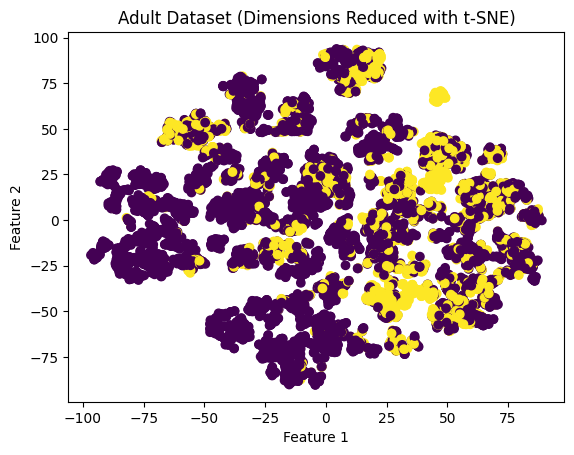

In [ ]:
adult_dataset_dim_reduced_X = TSNE(n_jobs=-1, random_state=SEED).fit_transform(adult_dataset_X)
plt.scatter(adult_dataset_dim_reduced_X[:, 0], adult_dataset_dim_reduced_X[:, 1], c=adult_dataset_y)
plt.title("Adult Dataset (Dimensions Reduced with t-SNE)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Testing Various Clustering Models on the Datasets

## K-means

In [ ]:
blobs_kmeans = KMeans(n_clusters=3, random_state=SEED).fit(blobs_X)
noisy_moons_kmeans = KMeans(n_clusters=2, random_state=SEED).fit(noisy_moons_X)
noisy_circles_kmeans = KMeans(n_clusters=2, random_state=SEED).fit(noisy_circles_X)
aniso_kmeans = KMeans(n_clusters=3, random_state=SEED).fit(aniso_X)
varied_blobs_kmeans = KMeans(n_clusters=3, random_state=SEED).fit(varied_blobs_X)
adult_kmeans = KMeans(n_clusters=2, random_state=SEED).fit(adult_dataset_X)

### Hyperparameter tuning for No Structure dataset

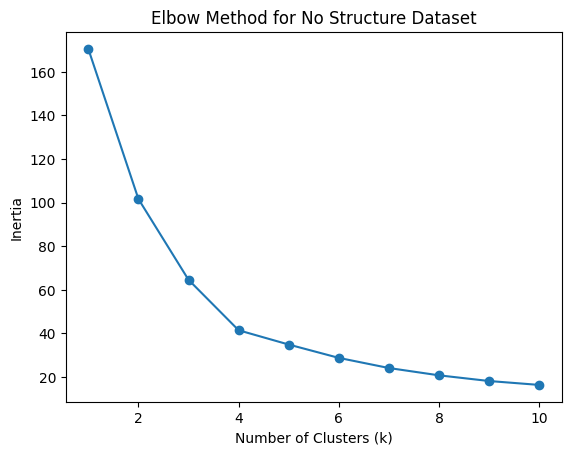

In [ ]:
k_values = range(1, 11)
inertia_values = [KMeans(n_clusters=k, random_state=SEED).fit(no_structure_X).inertia_ for k in k_values]
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for No Structure Dataset')
plt.show()

In [ ]:
no_structure_kmeans = KMeans(n_clusters=4, random_state=SEED).fit(no_structure_X)

### Evaluation

In [ ]:
print(f"silhouette_score for blobs dataset: {silhouette_score(blobs_X, blobs_kmeans.labels_):.3f}")
print(f"silhouette_score for noisy_moons dataset: {silhouette_score(noisy_moons_X, noisy_moons_kmeans.labels_):.3f}")
print(f"silhouette_score for noisy_circles dataset: {silhouette_score(noisy_circles_X, noisy_circles_kmeans.labels_):.3f}")
print(f"silhouette_score for aniso_ dataset: {silhouette_score(aniso_X, aniso_kmeans.labels_):.3f}")
print(f"silhouette_score for varied_blobs dataset: {silhouette_score(varied_blobs_X, varied_blobs_kmeans.labels_):.3f}")
print(f"silhouette_score for no_structure dataset: {silhouette_score(no_structure_X, no_structure_kmeans.labels_):.3f}")
print(f"silhouette_score for adult dataset: {silhouette_score(adult_dataset_X, adult_kmeans.labels_):.3f}")

print(f"ARI for blobs dataset: {adjusted_rand_score(blobs_y, blobs_kmeans.labels_):.3f}")
print(f"ARI for noisy_moons dataset: {adjusted_rand_score(noisy_moons_y, noisy_moons_kmeans.labels_):.3f}")
print(f"ARI for noisy_circles dataset: {adjusted_rand_score(noisy_circles_y, noisy_circles_kmeans.labels_):.3f}")
print(f"ARI for aniso_ dataset: {adjusted_rand_score(aniso_y, aniso_kmeans.labels_):.3f}")
print(f"ARI for varied_blobs dataset: {adjusted_rand_score(varied_blobs_y, varied_blobs_kmeans.labels_):.3f}")
print(f"ARI for adult dataset: {adjusted_rand_score(adult_dataset_y, adult_kmeans.labels_):.3f}")

silhouette_score for blobs dataset: 0.844
silhouette_score for noisy_moons dataset: 0.489
silhouette_score for noisy_circles dataset: 0.354
silhouette_score for aniso_ dataset: 0.702
silhouette_score for varied_blobs dataset: 0.777
silhouette_score for no_structure dataset: 0.413
silhouette_score for adult dataset: 0.162
ARI for blobs dataset: 1.000
ARI for noisy_moons dataset: 0.239
ARI for noisy_circles dataset: -0.001
ARI for aniso_ dataset: 0.991
ARI for varied_blobs dataset: 0.976
ARI for adult dataset: 0.036


## DBSCAN

### Hyperparameters tuning

In [ ]:
def find_dbscan_best_hyperparameters(X, evaluation_metric, labels_true=None):
    eps_range = [0.1, 0.5, 1.0, 1.5]
    min_samples_range = [3, 5, 7, 10]

    best_score = -1
    best_eps = 0.5
    best_min_samples = 5

    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
            labels_pred = dbscan.fit_predict(X)
            try:
                score = silhouette_score(X, labels_pred) if evaluation_metric == 'silhouette' else adjusted_rand_score(labels_true, labels_pred)
            except:
                score = -1

            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

    print(f"Best parameters: eps={best_eps}, min_samples={best_min_samples}")
    return best_eps, best_min_samples

best_eps, best_min_samples = find_dbscan_best_hyperparameters(X=blobs_X, evaluation_metric='silhouette')
blobs_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1).fit(blobs_X)

Best parameters: eps=1.0, min_samples=10


In [ ]:
best_eps, best_min_samples = find_dbscan_best_hyperparameters(X=noisy_moons_X, evaluation_metric='ari', labels_true=noisy_moons_y)
noisy_moons_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1).fit(noisy_moons_X)

Best parameters: eps=0.1, min_samples=3


In [ ]:
best_eps, best_min_samples = find_dbscan_best_hyperparameters(X=noisy_circles_X, evaluation_metric='ari', labels_true=noisy_circles_y)
noisy_circles_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1).fit(noisy_circles_X)

Best parameters: eps=0.1, min_samples=3


In [ ]:
best_eps, best_min_samples = find_dbscan_best_hyperparameters(X=aniso_X, evaluation_metric='silhouette')
aniso_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1).fit(aniso_X)

Best parameters: eps=0.5, min_samples=3


In [ ]:
best_eps, best_min_samples = find_dbscan_best_hyperparameters(X=varied_blobs_X, evaluation_metric='silhouette')
varied_blobs_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1).fit(varied_blobs_X)

Best parameters: eps=1.5, min_samples=10


In [ ]:
best_eps, best_min_samples = find_dbscan_best_hyperparameters(X=no_structure_X, evaluation_metric='silhouette')
no_structure_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1).fit(no_structure_X)

Best parameters: eps=0.5, min_samples=5


In [ ]:
best_eps, best_min_samples = find_dbscan_best_hyperparameters(X=adult_dataset_X, evaluation_metric='silhouette')
adult_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1).fit(adult_dataset_X)

Best parameters: eps=1.5, min_samples=10


### Evaluation

In [ ]:
print(f"silhouette_score for blobs dataset: {silhouette_score(blobs_X, blobs_dbscan.labels_):.3f}")
print(f"silhouette_score for noisy_moons dataset: {silhouette_score(noisy_moons_X, noisy_moons_dbscan.labels_):.3f}")
print(f"silhouette_score for noisy_circles dataset: {silhouette_score(noisy_circles_X, noisy_circles_dbscan.labels_):.3f}")
print(f"silhouette_score for aniso_ dataset: {silhouette_score(aniso_X, aniso_dbscan.labels_):.3f}")
print(f"silhouette_score for varied_blobs dataset: {silhouette_score(varied_blobs_X, varied_blobs_dbscan.labels_):.3f}")
# print(f"silhouette_score for no_structure dataset: {silhouette_score(no_structure_X, no_structure_dbscan.labels_):.3f}") # Number of labels is 1. Valid values are at least 2
print(f"silhouette_score for adult dataset: {silhouette_score(adult_dataset_X, adult_dbscan.labels_):.3f}")

print(f"ARI for blobs dataset: {adjusted_rand_score(blobs_y, blobs_dbscan.labels_):.3f}")
print(f"ARI for noisy_moons dataset: {adjusted_rand_score(noisy_moons_y, noisy_moons_dbscan.labels_):.3f}")
print(f"ARI for noisy_circles dataset: {adjusted_rand_score(noisy_circles_y, noisy_circles_dbscan.labels_):.3f}")
print(f"ARI for aniso_ dataset: {adjusted_rand_score(aniso_y, aniso_dbscan.labels_):.3f}")
print(f"ARI for varied_blobs dataset: {adjusted_rand_score(varied_blobs_y, varied_blobs_dbscan.labels_):.3f}")
print(f"ARI for adult dataset: {adjusted_rand_score(adult_dataset_y, adult_dbscan.labels_):.3f}")

silhouette_score for blobs dataset: 0.823
silhouette_score for noisy_moons dataset: 0.055
silhouette_score for noisy_circles dataset: 0.112
silhouette_score for aniso_ dataset: 0.696
silhouette_score for varied_blobs dataset: 0.713
silhouette_score for adult dataset: 0.089
ARI for blobs dataset: 0.992
ARI for noisy_moons dataset: 0.998
ARI for noisy_circles dataset: 1.000
ARI for aniso_ dataset: 0.988
ARI for varied_blobs dataset: 0.979
ARI for adult dataset: -0.006


## Hierarchical (Agglomerative)

### Hyperparameters tuning

In [ ]:
def find_agglomerative_best_hyperparameters(X, evaluation_metric, labels_true=None):
    linkage_range = ['ward', 'complete', 'average', 'single']
    best_score = -1
    best_linkage = 'ward'

    for linkage in linkage_range:
        agglomerative = AgglomerativeClustering(linkage=linkage)
        labels_pred = agglomerative.fit_predict(X)
        try:
            score = silhouette_score(X, labels_pred) if evaluation_metric == 'silhouette' else adjusted_rand_score(labels_true, labels_pred)
        except:
            score = -1

        if score > best_score:
            best_score = score
            best_linkage = linkage

    print(f"Best parameters: linkage={best_linkage}")
    return best_linkage

best_linkage = find_agglomerative_best_hyperparameters(X=blobs_X, evaluation_metric='silhouette')
blobs_agglomerative = AgglomerativeClustering(n_clusters=3, linkage=best_linkage).fit(blobs_X)

Best parameters: linkage=ward


In [ ]:
best_linkage = find_agglomerative_best_hyperparameters(X=noisy_moons_X, evaluation_metric='ari', labels_true=noisy_moons_y)
noisy_moons_agglomerative = AgglomerativeClustering(n_clusters=2, linkage=best_linkage).fit(noisy_moons_X)

Best parameters: linkage=single


In [ ]:
best_linkage = find_agglomerative_best_hyperparameters(X=noisy_circles_X, evaluation_metric='ari', labels_true=noisy_circles_y)
noisy_circles_agglomerative = AgglomerativeClustering(n_clusters=2, linkage=best_linkage).fit(noisy_circles_X)

Best parameters: linkage=single


In [ ]:
best_linkage = find_agglomerative_best_hyperparameters(X=aniso_X, evaluation_metric='silhouette')
aniso_agglomerative = AgglomerativeClustering(n_clusters=3, linkage=best_linkage).fit(aniso_X)

Best parameters: linkage=ward


In [ ]:
best_linkage = find_agglomerative_best_hyperparameters(X=varied_blobs_X, evaluation_metric='silhouette')
varied_blobs_agglomerative = AgglomerativeClustering(n_clusters=3, linkage=best_linkage).fit(varied_blobs_X)

Best parameters: linkage=ward


In [ ]:
best_linkage = find_agglomerative_best_hyperparameters(X=no_structure_X, evaluation_metric='silhouette')
no_structure_agglomerative = AgglomerativeClustering(n_clusters=4, linkage=best_linkage).fit(no_structure_X)

Best parameters: linkage=complete


In [ ]:
best_linkage = find_agglomerative_best_hyperparameters(X=adult_dataset_X, evaluation_metric='silhouette')
adult_agglomerative = AgglomerativeClustering(n_clusters=2, linkage=best_linkage).fit(adult_dataset_X)

Best parameters: linkage=complete


### Evaluation

In [ ]:
print(f"silhouette_score for blobs dataset: {silhouette_score(blobs_X, blobs_agglomerative.labels_):.3f}")
print(f"silhouette_score for noisy_moons dataset: {silhouette_score(noisy_moons_X, noisy_moons_agglomerative.labels_):.3f}")
print(f"silhouette_score for noisy_circles dataset: {silhouette_score(noisy_circles_X, noisy_circles_agglomerative.labels_):.3f}")
print(f"silhouette_score for aniso_ dataset: {silhouette_score(aniso_X, aniso_agglomerative.labels_):.3f}")
print(f"silhouette_score for varied_blobs dataset: {silhouette_score(varied_blobs_X, varied_blobs_agglomerative.labels_):.3f}")
print(f"silhouette_score for no_structure dataset: {silhouette_score(no_structure_X, no_structure_agglomerative.labels_):.3f}")
print(f"silhouette_score for adult dataset: {silhouette_score(adult_dataset_X, adult_agglomerative.labels_):.3f}")

print(f"ARI for blobs dataset: {adjusted_rand_score(blobs_y, blobs_agglomerative.labels_):.3f}")
print(f"ARI for noisy_moons dataset: {adjusted_rand_score(noisy_moons_y, noisy_moons_agglomerative.labels_):.3f}")
print(f"ARI for noisy_circles dataset: {adjusted_rand_score(noisy_circles_y, noisy_circles_agglomerative.labels_):.3f}")
print(f"ARI for aniso_ dataset: {adjusted_rand_score(aniso_y, aniso_agglomerative.labels_):.3f}")
print(f"ARI for varied_blobs dataset: {adjusted_rand_score(varied_blobs_y, varied_blobs_agglomerative.labels_):.3f}")
print(f"ARI for adult dataset: {adjusted_rand_score(adult_dataset_y, adult_agglomerative.labels_):.3f}")

silhouette_score for blobs dataset: 0.844
silhouette_score for noisy_moons dataset: 0.334
silhouette_score for noisy_circles dataset: 0.112
silhouette_score for aniso_ dataset: 0.701
silhouette_score for varied_blobs dataset: 0.776
silhouette_score for no_structure dataset: 0.344
silhouette_score for adult dataset: 0.681
ARI for blobs dataset: 1.000
ARI for noisy_moons dataset: 1.000
ARI for noisy_circles dataset: 1.000
ARI for aniso_ dataset: 1.000
ARI for varied_blobs dataset: 0.994
ARI for adult dataset: 0.026


### Hierarchical Clustering Dendrogram for noisy moons dataset

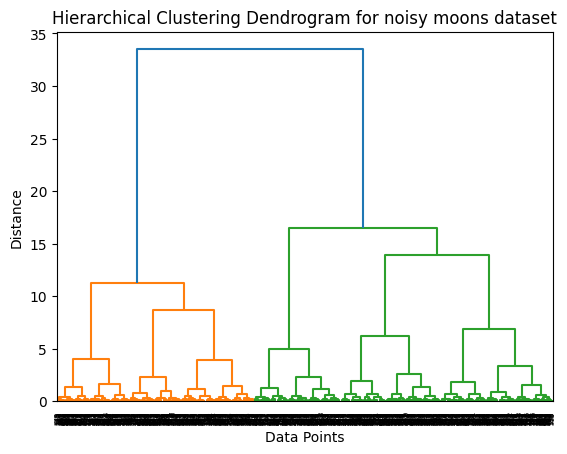

In [ ]:
linkage_matrix = linkage(noisy_moons_X, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram for noisy moons dataset')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

## Gaussian mixture model (GMM)

### Hyperparameters tuning

In [ ]:
def find_gmm_best_hyperparameters(X, evaluation_metric, labels_true=None):
    param_grid = {
        'n_components': [2, 3, 4, 5],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'init_params': ['kmeans', 'random'],
        'max_iter': [50, 100, 200]
    }

    best_score = -1
    best_params = {'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 100, 'n_components': 1}

    for params in ParameterGrid(param_grid):
        gmm = GaussianMixture(**params, random_state=SEED)
        labels_pred = gmm.fit_predict(X)
        try:
            score = silhouette_score(X, labels_pred) if evaluation_metric == 'silhouette' else adjusted_rand_score(labels_true, labels_pred)
        except:
            score = -1

        if score > best_score:
            best_score = score
            best_params = params

    print("Best parameters:", best_params)
    return best_params

best_params = find_gmm_best_hyperparameters(X=blobs_X, evaluation_metric='silhouette')
blobs_gmm = GaussianMixture(**best_params, random_state=SEED).fit(blobs_X)

Best parameters: {'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 50, 'n_components': 3}


In [ ]:
best_params = find_gmm_best_hyperparameters(X=noisy_moons_X, evaluation_metric='ari', labels_true=noisy_moons_y)
noisy_moons_gmm = GaussianMixture(**best_params, random_state=SEED).fit(noisy_moons_X)

Best parameters: {'covariance_type': 'full', 'init_params': 'random', 'max_iter': 50, 'n_components': 4}


In [ ]:
best_params = find_gmm_best_hyperparameters(X=noisy_circles_X, evaluation_metric='ari', labels_true=noisy_circles_y)
noisy_circles_gmm = GaussianMixture(**best_params, random_state=SEED).fit(noisy_circles_X)

Best parameters: {'covariance_type': 'diag', 'init_params': 'random', 'max_iter': 50, 'n_components': 3}


In [ ]:
best_params = find_gmm_best_hyperparameters(X=aniso_X, evaluation_metric='silhouette')
aniso_gmm = GaussianMixture(**best_params, random_state=SEED).fit(aniso_X)

Best parameters: {'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 50, 'n_components': 2}


In [ ]:
best_params = find_gmm_best_hyperparameters(X=varied_blobs_X, evaluation_metric='silhouette')
varied_blobs_gmm = GaussianMixture(**best_params, random_state=SEED).fit(varied_blobs_X)

Best parameters: {'covariance_type': 'tied', 'init_params': 'kmeans', 'max_iter': 50, 'n_components': 3}


In [ ]:
best_params = find_gmm_best_hyperparameters(X=no_structure_X, evaluation_metric='silhouette')
no_structure_gmm = GaussianMixture(**best_params, random_state=SEED).fit(no_structure_X)

Best parameters: {'covariance_type': 'spherical', 'init_params': 'kmeans', 'max_iter': 50, 'n_components': 4}


In [ ]:
best_params = find_gmm_best_hyperparameters(X=adult_dataset_X, evaluation_metric='silhouette')
adult_gmm = GaussianMixture(**best_params, random_state=SEED).fit(adult_dataset_X)

Best parameters: {'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 50, 'n_components': 2}


### Evaluation

In [ ]:
print(f"silhouette_score for blobs dataset: {silhouette_score(blobs_X, blobs_gmm.predict(blobs_X)):.3f}")
print(f"silhouette_score for noisy_moons dataset: {silhouette_score(noisy_moons_X, noisy_moons_gmm.predict(noisy_moons_X)):.3f}")
print(f"silhouette_score for noisy_circles dataset: {silhouette_score(noisy_circles_X, noisy_circles_gmm.predict(noisy_circles_X)):.3f}")
print(f"silhouette_score for aniso_ dataset: {silhouette_score(aniso_X, aniso_gmm.predict(aniso_X)):.3f}")
print(f"silhouette_score for varied_blobs dataset: {silhouette_score(varied_blobs_X, varied_blobs_gmm.predict(varied_blobs_X)):.3f}")
print(f"silhouette_score for no_structure dataset: {silhouette_score(no_structure_X, no_structure_gmm.predict(no_structure_X)):.3f}")
print(f"silhouette_score for adult dataset: {silhouette_score(adult_dataset_X, adult_gmm.predict(adult_dataset_X)):.3f}")

print(f"ARI for blobs dataset: {adjusted_rand_score(blobs_y, blobs_gmm.predict(blobs_X)):.3f}")
print(f"ARI for noisy_moons dataset: {adjusted_rand_score(noisy_moons_y, noisy_moons_gmm.predict(noisy_moons_X)):.3f}")
print(f"ARI for noisy_circles dataset: {adjusted_rand_score(noisy_circles_y, noisy_circles_gmm.predict(noisy_circles_X)):.3f}")
print(f"ARI for aniso_ dataset: {adjusted_rand_score(aniso_y, aniso_gmm.predict(aniso_X)):.3f}")
print(f"ARI for varied_blobs dataset: {adjusted_rand_score(varied_blobs_y, varied_blobs_gmm.predict(varied_blobs_X)):.3f}")
print(f"ARI for adult dataset: {adjusted_rand_score(adult_dataset_y, adult_gmm.predict(adult_dataset_X)):.3f}")

silhouette_score for blobs dataset: 0.844
silhouette_score for noisy_moons dataset: 0.345
silhouette_score for noisy_circles dataset: 0.105
silhouette_score for aniso_ dataset: 0.806
silhouette_score for varied_blobs dataset: 0.777
silhouette_score for no_structure dataset: 0.413
silhouette_score for adult dataset: 0.191
ARI for blobs dataset: 1.000
ARI for noisy_moons dataset: 0.688
ARI for noisy_circles dataset: 0.111
ARI for aniso_ dataset: 0.572
ARI for varied_blobs dataset: 0.979
ARI for adult dataset: 0.185


## Plotting all clustering results

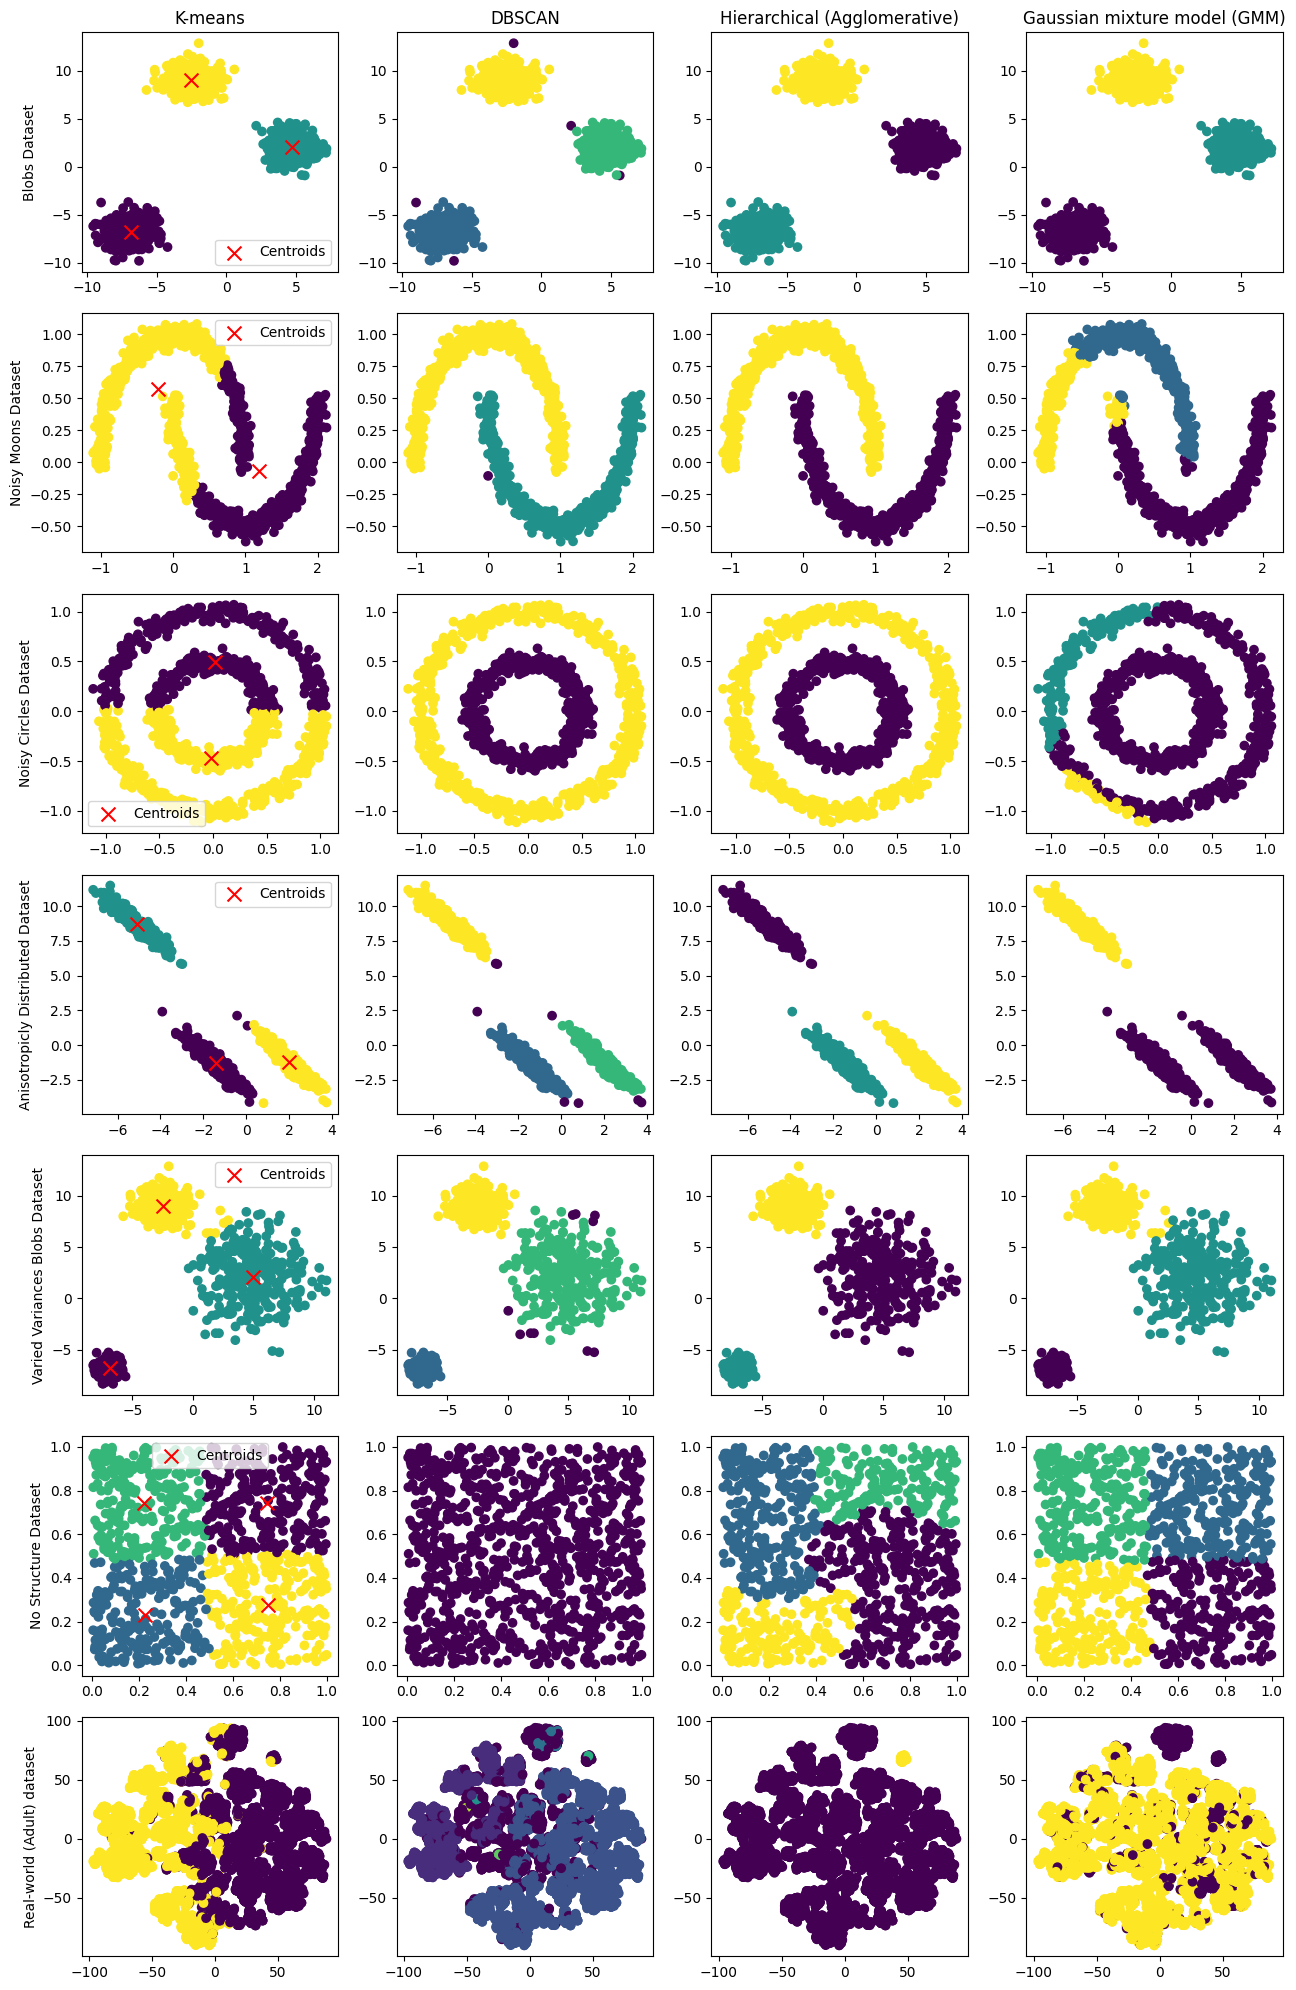

In [ ]:
fig, ax = plt.subplots(7, 4, figsize=(13, 20))
ax[0, 0].scatter(blobs_X[:, 0], blobs_X[:, 1], c=blobs_kmeans.labels_)
ax[0, 0].scatter(blobs_kmeans.cluster_centers_[:, 0], blobs_kmeans.cluster_centers_[:, 1], s=100, c='red', label='Centroids', marker='x')
ax[0, 0].set_ylabel('Blobs Dataset')
ax[0, 0].legend()
ax[0, 0].set_title("K-means")
ax[0, 1].scatter(blobs_X[:, 0], blobs_X[:, 1], c=blobs_dbscan.labels_)
ax[0, 1].set_title("DBSCAN")
ax[0, 2].scatter(blobs_X[:, 0], blobs_X[:, 1], c=blobs_agglomerative.labels_)
ax[0, 2].set_title("Hierarchical (Agglomerative)")
ax[0, 3].scatter(blobs_X[:, 0], blobs_X[:, 1], c=blobs_gmm.predict(blobs_X))
ax[0, 3].set_title("Gaussian mixture model (GMM)")
ax[1, 0].scatter(noisy_moons_X[:, 0], noisy_moons_X[:, 1], c=noisy_moons_kmeans.labels_)
ax[1, 0].scatter(noisy_moons_kmeans.cluster_centers_[:, 0], noisy_moons_kmeans.cluster_centers_[:, 1], s=100, c='red', label='Centroids', marker='x')
ax[1, 0].set_ylabel('Noisy Moons Dataset')
ax[1, 0].legend()
ax[1, 1].scatter(noisy_moons_X[:, 0], noisy_moons_X[:, 1], c=noisy_moons_dbscan.labels_)
ax[1, 2].scatter(noisy_moons_X[:, 0], noisy_moons_X[:, 1], c=noisy_moons_agglomerative.labels_)
ax[1, 3].scatter(noisy_moons_X[:, 0], noisy_moons_X[:, 1], c=noisy_moons_gmm.predict(noisy_moons_X))
ax[2, 0].scatter(noisy_circles_X[:, 0], noisy_circles_X[:, 1], c=noisy_circles_kmeans.labels_)
ax[2, 0].scatter(noisy_circles_kmeans.cluster_centers_[:, 0], noisy_circles_kmeans.cluster_centers_[:, 1], s=100, c='red', label='Centroids', marker='x')
ax[2, 0].set_ylabel('Noisy Circles Dataset')
ax[2, 0].legend()
ax[2, 1].scatter(noisy_circles_X[:, 0], noisy_circles_X[:, 1], c=noisy_circles_dbscan.labels_)
ax[2, 2].scatter(noisy_circles_X[:, 0], noisy_circles_X[:, 1], c=noisy_circles_agglomerative.labels_)
ax[2, 3].scatter(noisy_circles_X[:, 0], noisy_circles_X[:, 1], c=noisy_circles_gmm.predict(noisy_circles_X))
ax[3, 0].scatter(aniso_X[:, 0], aniso_X[:, 1], c=aniso_kmeans.labels_)
ax[3, 0].scatter(aniso_kmeans.cluster_centers_[:, 0], aniso_kmeans.cluster_centers_[:, 1], s=100, c='red', label='Centroids', marker='x')
ax[3, 0].set_ylabel('Anisotropicly Distributed Dataset')
ax[3, 0].legend()
ax[3, 1].scatter(aniso_X[:, 0], aniso_X[:, 1], c=aniso_dbscan.labels_)
ax[3, 2].scatter(aniso_X[:, 0], aniso_X[:, 1], c=aniso_agglomerative.labels_)
ax[3, 3].scatter(aniso_X[:, 0], aniso_X[:, 1], c=aniso_gmm.predict(aniso_X))
ax[4, 0].scatter(varied_blobs_X[:, 0], varied_blobs_X[:, 1], c=varied_blobs_kmeans.labels_)
ax[4, 0].scatter(varied_blobs_kmeans.cluster_centers_[:, 0], varied_blobs_kmeans.cluster_centers_[:, 1], s=100, c='red', label='Centroids', marker='x')
ax[4, 0].set_ylabel('Varied Variances Blobs Dataset')
ax[4, 0].legend()
ax[4, 1].scatter(varied_blobs_X[:, 0], varied_blobs_X[:, 1], c=varied_blobs_dbscan.labels_)
ax[4, 2].scatter(varied_blobs_X[:, 0], varied_blobs_X[:, 1], c=varied_blobs_agglomerative.labels_)
ax[4, 3].scatter(varied_blobs_X[:, 0], varied_blobs_X[:, 1], c=varied_blobs_gmm.predict(varied_blobs_X))
ax[5, 0].scatter(no_structure_X[:, 0], no_structure_X[:, 1], c=no_structure_kmeans.labels_)
ax[5, 0].scatter(no_structure_kmeans.cluster_centers_[:, 0], no_structure_kmeans.cluster_centers_[:, 1], s=100, c='red', label='Centroids', marker='x')
ax[5, 0].set_ylabel('No Structure Dataset')
ax[5, 0].legend()
ax[5, 1].scatter(no_structure_X[:, 0], no_structure_X[:, 1], c=no_structure_dbscan.labels_)
ax[5, 2].scatter(no_structure_X[:, 0], no_structure_X[:, 1], c=no_structure_agglomerative.labels_)
ax[5, 3].scatter(no_structure_X[:, 0], no_structure_X[:, 1], c=no_structure_gmm.predict(no_structure_X))
ax[6, 0].scatter(adult_dataset_dim_reduced_X[:, 0], adult_dataset_dim_reduced_X[:, 1], c=adult_kmeans.labels_)
ax[6, 0].set_ylabel('Real-world (Adult) dataset')
ax[6, 1].scatter(adult_dataset_dim_reduced_X[:, 0], adult_dataset_dim_reduced_X[:, 1], c=adult_dbscan.labels_)
ax[6, 2].scatter(adult_dataset_dim_reduced_X[:, 0], adult_dataset_dim_reduced_X[:, 1], c=adult_agglomerative.labels_)
ax[6, 3].scatter(adult_dataset_dim_reduced_X[:, 0], adult_dataset_dim_reduced_X[:, 1], c=adult_gmm.predict(adult_dataset_X))
fig.tight_layout()
fig.show()